In [31]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
import random
import os


In [32]:
SEED = 42
random.seed(SEED)

np.random.seed(SEED)

import sklearn
sklearn.utils.check_random_state(SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)

In [33]:
import requests
import pandas as pd
from io import StringIO

url = "https://osf.io/7s5yb/download?version=1"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text))

info = df.info()
head = df.head()
columns = df.columns.tolist()

desc = df.describe(include='all')

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1.001034e+06,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1.001034e+06,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1.001034e+06,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1.001034e+06,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1.001034e+06,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287824,4.641209e+11,2011-01-01,2011-12-31,NaN,0.000000,1807.407349,3.703704,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287825,4.641209e+11,2012-01-01,2012-12-31,NaN,0.000000,1518.518555,96.296295,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287826,4.641209e+11,2013-01-01,2013-12-31,NaN,0.000000,988.888916,77.777779,0.0,0.0,0.0,...,NaN,NaN,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287827,4.641209e+11,2014-01-01,2014-12-31,NaN,0.000000,644.444458,233.333328,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN


In [ ]:
print(df["year"].min(), "→", df["year"].max())

df = (
    df.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = df.replace("toReplace", np.nan)  

2005 → 2016


In [35]:

df['year'] = df['year'].astype(int)
df = df[(df['year'] >= 2010) & (df['year'] <= 2015)].copy()

df = df.drop(columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"], errors='ignore')


df.sort_values(by=['comp_id', 'year'], inplace=True)

df['sales_next'] = df.groupby('comp_id')['sales'].shift(-1)
df['labor_next'] = df.groupby('comp_id')['labor_avg'].shift(-1)
df['year_next'] = df.groupby('comp_id')['year'].shift(-1)
df['exit_year'] = pd.to_numeric(df['exit_year'], errors='coerce')

df = df[
    (df['exit_year'].isna()) | (df['exit_year'] > df['year'])
]

df_clean = df.dropna(subset=['sales', 'sales_next'])

df_clean


,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,sales_next,labor_next,year_next
5,1.001034e+06,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,637.037048,...,56.0,3.0,1,Central,1990-11-19,NaN,0.083333,0.000000,0.083333,2011.0
6,1.001034e+06,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,481.481476,...,56.0,3.0,1,Central,1990-11-19,NaN,0.083333,0.000000,0.083333,2012.0
7,1.001034e+06,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,340.740753,...,56.0,3.0,1,Central,1990-11-19,NaN,0.083333,0.000000,NaN,2013.0
8,1.001034e+06,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,200.000000,...,56.0,3.0,1,Central,1990-11-19,NaN,NaN,0.000000,NaN,2014.0
9,1.001034e+06,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,170.370377,...,56.0,3.0,1,Central,1990-11-19,NaN,NaN,0.000000,NaN,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287823,4.641209e+11,2010-01-01,2010-12-31,0.000000,1781.481445,0.000000,0.0,0.0,0.0,0.000000,...,55.0,3.0,2,East,1990-08-22,NaN,NaN,288.888885,NaN,2011.0
287824,4.641209e+11,2011-01-01,2011-12-31,0.000000,1807.407349,3.703704,0.0,0.0,0.0,0.000000,...,55.0,3.0,2,East,1990-08-22,NaN,NaN,0.000000,NaN,2012.0
287825,4.641209e+11,2012-01-01,2012-12-31,0.000000,1518.518555,96.296295,0.0,0.0,0.0,0.000000,...,55.0,3.0,2,East,1990-08-22,NaN,NaN,0.000000,NaN,2013.0
287826,4.641209e+11,2013-01-01,2013-12-31,0.000000,988.888916,77.777779,0.0,0.0,0.0,0.000000,...,55.0,3.0,2,East,1990-08-22,NaN,NaN,0.000000,NaN,2014.0


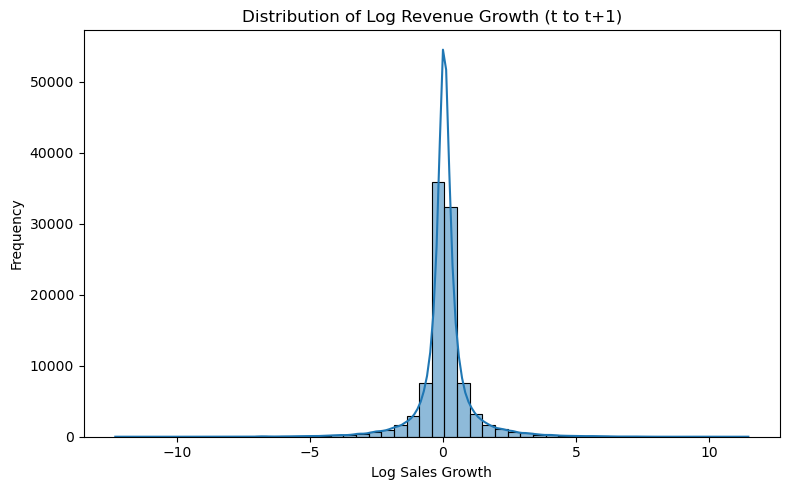

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,ind,urban_m,region_m,founded_date,exit_date,labor_avg,sales_next,labor_next,year_next,log_sales_growth
5,1001034.0,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,637.037048,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,0.083333,2011.0,-inf
6,1001034.0,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,481.481476,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,0.083333,2012.0,NaN
7,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,340.740753,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,NaN,2013.0,NaN
8,1001034.0,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,200.000000,...,3.0,1,Central,1990-11-19,NaN,NaN,0.0,NaN,2014.0,NaN
9,1001034.0,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,170.370377,...,3.0,1,Central,1990-11-19,NaN,NaN,0.0,NaN,2015.0,NaN


In [36]:

df_clean['log_sales_growth'] = np.log(df_clean['sales_next'] / df_clean['sales'])

plt.figure(figsize=(8, 5))
sns.histplot(df_clean['log_sales_growth'], bins=50, kde=True)
plt.title("Distribution of Log Revenue Growth (t to t+1)")
plt.xlabel("Log Sales Growth")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

df_clean.head()


In [37]:
df_sales = df[["comp_id", "year", "sales", "exit_year"]].copy()

# Step 2: Filter to the years needed for CAGR
df_sales = df_sales[df_sales["year"].isin([2012, 2013, 2014])]

# Step 3: Pivot so each firm has sales per year in separate columns
sales_pivot = df_sales.pivot(index="comp_id", columns="year", values="sales")

# Step 4: Count firms with non-missing sales in both 2012 and 2014
valid_cagr_firms = sales_pivot.dropna(subset=[2012, 2014]).shape[0]

# Step 5: Total firms with non-missing sales in 2012
firms_2012 = sales_pivot[2012].notna().sum()

# Step 6: Calculate the feasibility ratio
cagr_feasibility = valid_cagr_firms / firms_2012 * 100

# Step 7: Summary
print("Number of firms with sales in 2012:", firms_2012)
print("Number of firms with sales in both 2012 and 2014:", valid_cagr_firms)
print(f"Percentage of 2012 firms eligible for CAGR: {cagr_feasibility:.2f}%")

Number of firms with sales in 2012: 27382
Number of firms with sales in both 2012 and 2014: 23104
Percentage of 2012 firms eligible for CAGR: 84.38%


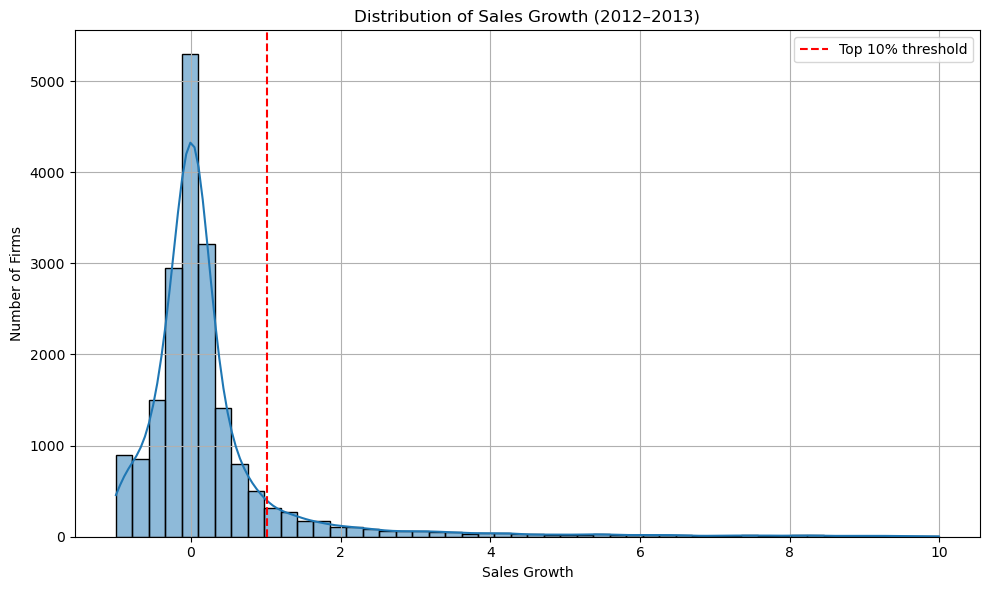

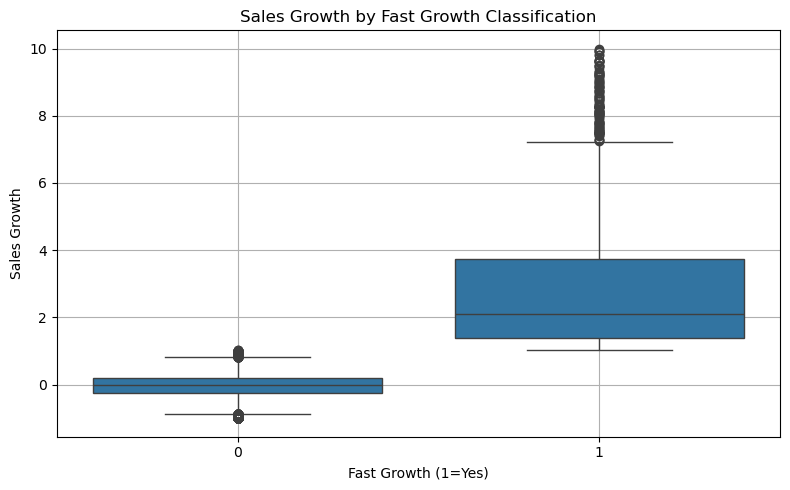

,count,mean,std,min,25%,50%,75%,max
fast_growth_sales,,,,,,,,
0,17501.0,-0.026652,0.395088,-0.999920,-0.234367,-0.003294,0.186793,1.017191
1,1945.0,2.932825,2.075908,1.018734,1.400000,2.109517,3.730290,9.992043


In [43]:

# Step 3: Drop rows with missing sales
df = df[~df['sales'].isna()]

# Step 4: Create next year's sales to compute growth
df = df.sort_values(['comp_id', 'year'])
df['sales_next'] = df.groupby('comp_id')['sales'].shift(-1)
df['year_next'] = df.groupby('comp_id')['year'].shift(-1)

# Step 5: Filter to base year = 2012 for now (can test other windows later)
df_growth = df[(df['year'] == 2012) & (~df['sales_next'].isna())]

# Step 6: Drop if firm exited before 2013
df_growth = df_growth[(df_growth['exit_year'].isna()) | (df_growth['exit_year'] > 2013)]

# Step 7: Calculate sales growth
df_growth['sales_growth'] = (df_growth['sales_next'] / df_growth['sales']) - 1

# Step 8: Drop implausible growth rates (outliers or data errors)
df_growth = df_growth[(df_growth['sales_growth'] > -1) & (df_growth['sales_growth'] < 10)]

# Step 9: Create binary target: Top 10% sales growth in 2012–2013
growth_threshold = df_growth['sales_growth'].quantile(0.90)
df_growth['fast_growth_sales'] = (df_growth['sales_growth'] >= growth_threshold).astype(int)

# Plot distribution of sales growth
plt.figure(figsize=(10, 6))
sns.histplot(df_growth['sales_growth'], bins=50, kde=True)
plt.axvline(growth_threshold, color='red', linestyle='--', label='Top 10% threshold')
plt.title('Distribution of Sales Growth (2012–2013)')
plt.xlabel('Sales Growth')
plt.ylabel('Number of Firms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of sales growth by fast_growth label
plt.figure(figsize=(8, 5))
sns.boxplot(x='fast_growth_sales', y='sales_growth',data=df_growth)
plt.title('Sales Growth by Fast Growth Classification')
plt.xlabel('Fast Growth (1=Yes)')
plt.ylabel('Sales Growth')
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary stats by fast_growth group
summary_stats = df_growth.groupby('fast_growth_sales')['sales_growth'].describe()
summary_stats

In [38]:

df_growth = df[["comp_id", "year", "sales", "exit_year"]]
df_growth = df_growth[df_growth["year"].isin([2012, 2013, 2014])]

sales_wide = df_growth.pivot(index="comp_id", columns="year", values="sales")

exit_info = df.groupby("comp_id")["exit_year"].first()
active_firms = exit_info[(exit_info.isna()) | (exit_info >= 2014)].index
sales_wide = sales_wide.loc[sales_wide.index.isin(active_firms)]

# Compute CAGR between 2012 and 2014
sales_wide["cagr_12_14"] = np.power(sales_wide[2014] / sales_wide[2012], 1/2) - 1

# Compute 1-year sales growth from 2012 to 2013
sales_wide["growth_12_13"] = (sales_wide[2013] - sales_wide[2012]) / sales_wide[2012]

# Drop infinite or NaN results (e.g., due to zero or missing sales in base years)
sales_wide = sales_wide.replace([np.inf, -np.inf], np.nan).dropna(subset=["cagr_12_14", "growth_12_13"])

# Create binary labels: top 10% = fast growth
sales_wide["fast_growth_cagr"] = (sales_wide["cagr_12_14"] > sales_wide["cagr_12_14"].quantile(0.9)).astype(int)
sales_wide["fast_growth_growth"] = (sales_wide["growth_12_13"] > sales_wide["growth_12_13"].quantile(0.9)).astype(int)

# Output head of labeled data
sales_wide[["cagr_12_14", "growth_12_13", "fast_growth_cagr", "fast_growth_growth"]].head()


year,cagr_12_14,growth_12_13,fast_growth_cagr,fast_growth_growth
comp_id,,,,
1001541.0,1.015326,3.615385,1,1
1002029.0,-0.563289,-0.684947,0,0
1011889.0,0.044210,0.019293,0,0
1014183.0,-0.117423,-0.104205,0,0
1018301.0,0.162310,0.256749,0,0
